# Import Library

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import yfinance as yf

# Data Collection

In [56]:
df = yf.download('UNVR.JK', start='2005-01-01', end='2025-01-01')
df.index.name = 'Date'

df.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4937 entries, 2005-01-03 to 2024-12-30
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, UNVR.JK)   4937 non-null   float64
 1   (High, UNVR.JK)    4937 non-null   float64
 2   (Low, UNVR.JK)     4937 non-null   float64
 3   (Open, UNVR.JK)    4937 non-null   float64
 4   (Volume, UNVR.JK)  4937 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 231.4 KB


# Data Preprocessing

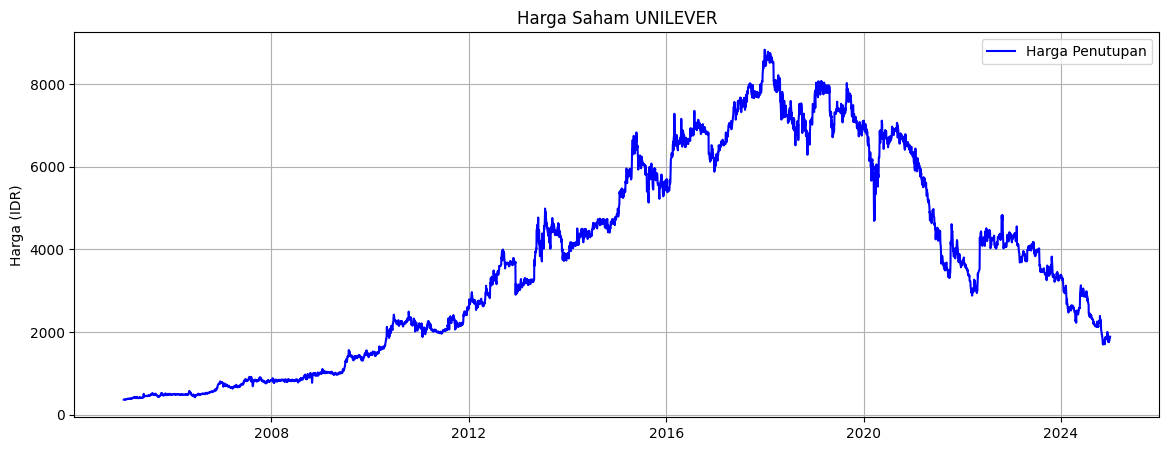

In [40]:
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='Harga Penutupan', color='blue')
plt.title('Harga Saham UNILEVER')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.grid(True)
plt.show()


ms = MinMaxScaler()
df['Close_ms'] = ms.fit_transform(df[['Close']])

train_size = 0.8
size = int(len(df) * train_size)
train, test = df['Close_ms'].iloc[:size], df['Close_ms'].iloc[size:]

# Feature Engineering

In [41]:
def split_target(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 1
X_train, y_train = split_target(train.values, look_back)
X_test, y_test = split_target(test.values, look_back)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Model Selection

In [42]:
model = Sequential([
    LSTM(128, input_shape=(1, look_back), return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.Huber(),
              metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Model Training

In [43]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    validation_data=(X_test, y_test), shuffle=False,
                    callbacks=[EarlyStopping(monitor='val_mae', patience=10)])

Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0253 - mae: 0.1311 - val_loss: 0.0258 - val_mae: 0.2007
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0162 - mae: 0.1490 - val_loss: 0.0043 - val_mae: 0.0711
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0243 - mae: 0.2055 - val_loss: 0.0065 - val_mae: 0.1008
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0325 - mae: 0.2357 - val_loss: 0.0083 - val_mae: 0.1173
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0291 - mae: 0.2218 - val_loss: 0.0071 - val_mae: 0.1097
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0227 - mae: 0.1950 - val_loss: 0.0053 - val_mae: 0.0956
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - mae: 0.1638 - val_loss: 0.0035 - val_mae: 0.0774
Epoch 8/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - mae: 0.1327 - val_loss: 0.0019 - val_mae: 0.0570
Epoch 9/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 12m

# Model Evaluation

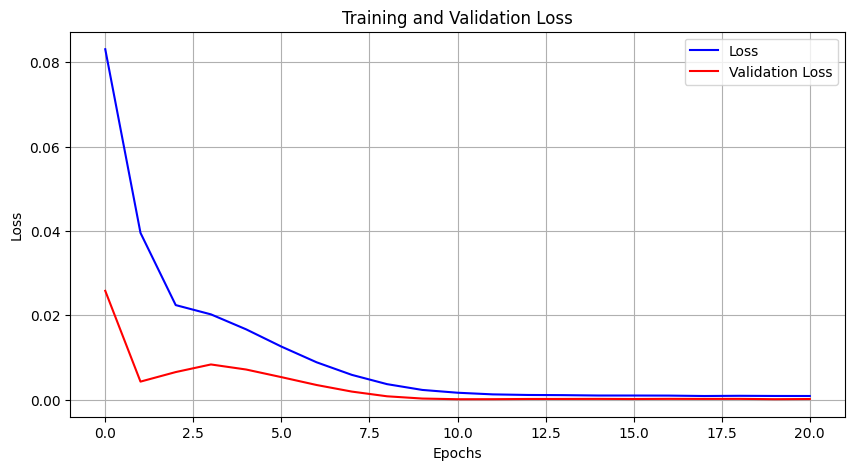

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MAE: 0.01369470420225656, RMSE: 0.016755807441956847, MAPE: 0.03321364355690878


In [44]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


pred = model.predict(X_test)
y_pred = np.array(pred).reshape(-1)


mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

# Prediction

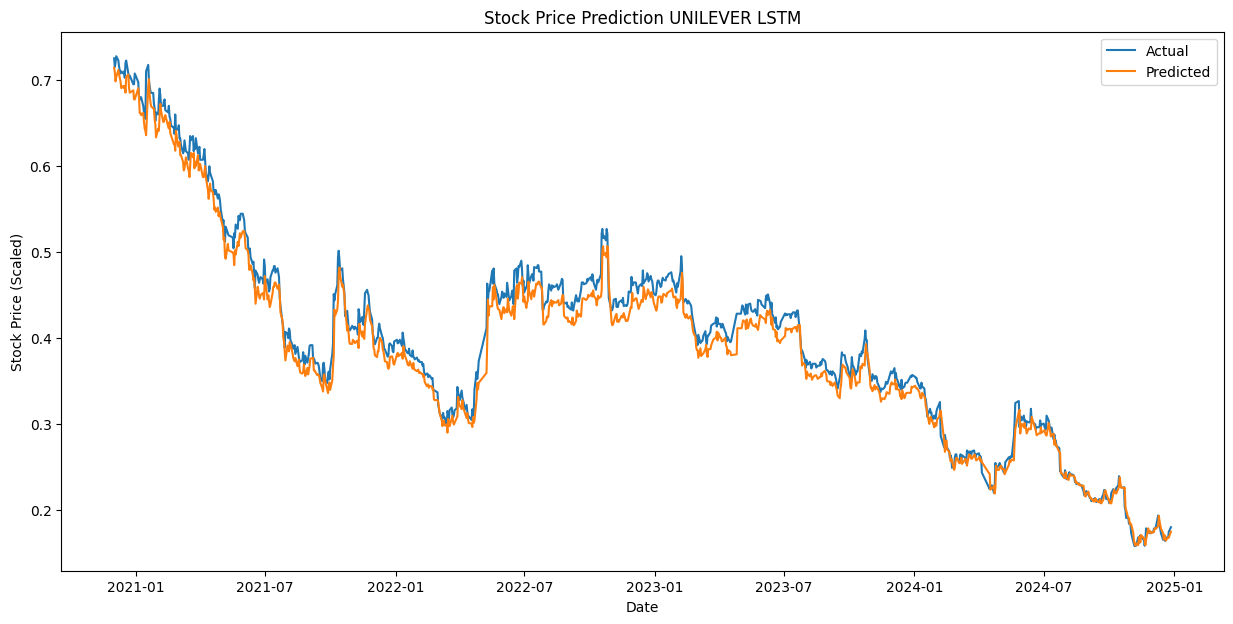

In [45]:
plt.figure(figsize=(15, 7))
plt.plot(test.index[:-1], y_test, label='Actual')
plt.plot(test.index[:-1], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price (Scaled)')
plt.title('Stock Price Prediction UNILEVER LSTM')
plt.legend()
plt.show()